<a href="https://colab.research.google.com/github/SibeleTatiana/D_L-Models/blob/main/moledo_plantas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import imghdr
from PIL import Image

In [3]:
from zipfile import ZipFile

# Enviar o arquivo manualmente no Colab e ajustar o nome se necessário
zip_path = "/content/Plantas_test_treino.zip"
extract_path = "/content/Plantas_test_treino"

# Descompactar
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [4]:
def limpar_e_converter_imagens(diretorio):
    erros = []
    for root, dirs, files in os.walk(diretorio):
        for file in files:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    img.convert("RGB")  # força formato RGB
                    img.save(path)      # reescreve a imagem
            except Exception as e:
                erros.append(path)
                os.remove(path)
                print(f"Removido inválido: {path}")
    print(f"\nTotal de imagens removidas: {len(erros)}")

limpar_e_converter_imagens("/content/Plantas_test_treino")


Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/8.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/2.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/9.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/4.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/5.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/11.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/13.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/6.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/7.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/10.jpg
Removido inválido: /content/Plantas_test_treino/Plantas_test_treino/Violeta_Palustre/12

In [5]:

# Parâmetros
base_dir = "/content/Plantas_test_treino"
img_height = 224
img_width = 224
batch_size = 16
seed = 123


In [6]:

# Remover imagens inválidas
for root, dirs, files in os.walk(base_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if imghdr.what(file_path) is None:
            print(f"Removendo inválido: {file_path}")
            os.remove(file_path)


In [7]:
# Carregar o dataset
train_ds_original = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_original = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Obter classes antes do prefetch
class_names = train_ds_original.class_names
num_classes = len(class_names)

# Otimizar com prefetch depois
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_original.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_original.prefetch(buffer_size=AUTOTUNE)

print("Classes:", class_names)


Found 49 files belonging to 1 classes.
Using 40 files for training.
Found 49 files belonging to 1 classes.
Using 9 files for validation.
Classes: ['Plantas_test_treino']


In [8]:

# Modelo CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Treinar o modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 

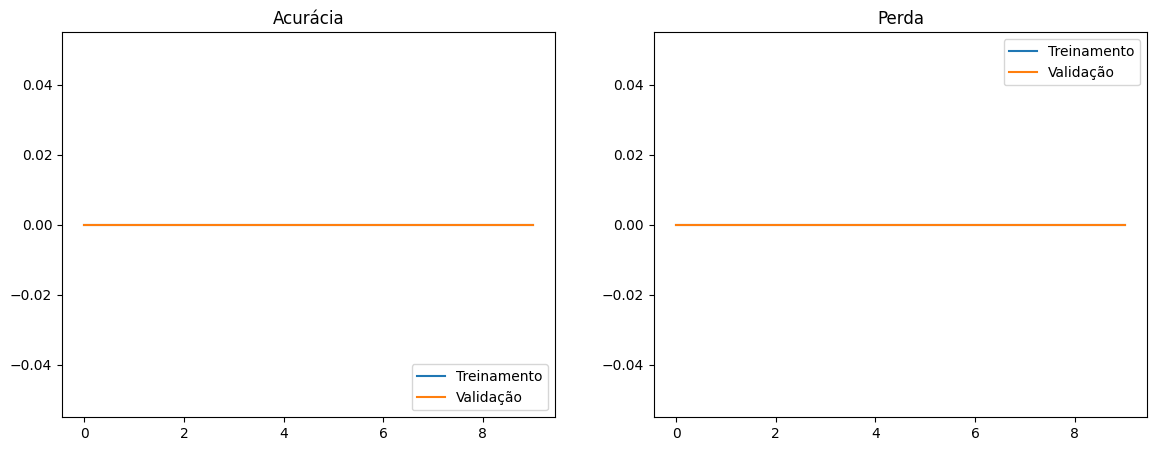

In [10]:

# Visualizar acurácia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treinamento')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend(loc='lower right')
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treinamento')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend(loc='upper right')
plt.title('Perda')

plt.show()
